## The Central Dogma

Replication: DNA is copied during cell division so the two daughter cells inherit the same genetic information. 

Transcription: the information in the DNA of every cell is converted into small, portable RNA messages.

Translation: During translation, these messages travel from where the DNA is in the cell nucleus to the ribosomes where they are ‘read’ to make specific proteins.

Consider a gene that is regulated by a transcription factor $T$, and let M denote the RNA molecular species resulting from this gene transcription. Under the assumption that chemical kinetics can be used to model gene expression and gene regulation, we can write the following reaction:

$$
\begin{matrix}
T+D &\overset{k_M}{\longrightarrow}& M \tag{1}\\ 
M &\overset{\gamma_M}{\longrightarrow}& 0 
\end{matrix}
$$

The equation governing the dynamics of the RNA concentration [M] is:

$$
\frac{\mathrm{d} [M]}{\mathrm{d} t}=  k_M [D]  [T]- \gamma_M [M] \tag{2}
$$


where

- $[M]$ is the concentration of mRNA 
- $[D]$ is the concentration of gene copies
- $[T]$ is the transcription factor
- $k_M$ is the maximum transcription rate of a gene copy 
- $\gamma_M$ is the RNA degradation rate 

The dynamics of transcription can be found by numerically simulating the system


In [1]:
using Plots; gr()
using DifferentialEquations

In [2]:
function CentralDogma1!(du,u,p,t)
    k_M,γ_M,T,D= p
    du[1] = -γ_M*u[1]+k_M*T*D
end

CentralDogma1! (generic function with 1 method)

In [3]:
CentralDogma1_DSL! = @ode_def ab begin
   dM = -γ_M*M+k_M*T*D
    end k_M γ_M T D

(::ab{getfield(Main, Symbol("##3#7")),getfield(Main, Symbol("##4#8")),getfield(Main, Symbol("##5#9")),Nothing,Nothing,getfield(Main, Symbol("##6#10")),Expr,Expr}) (generic function with 2 methods)

In [4]:
k_M=1
γ_M=1
T=1
D=1
p=[k_M,γ_M,T,D];
tspan = (0.0,10.0)
u0=[0.02]
prob1 = ODEProblem(CentralDogma1_DSL!,u0,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [0.02]

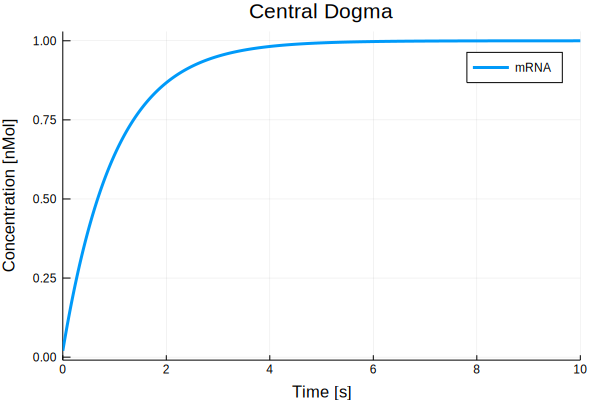

In [5]:
sol1 = solve(prob1)
plot(sol1,label=["mRNA"])
title!("Central Dogma")
xlabel!("Time [s]")
ylabel!("Concentration [nMol]")

Normally, one molecule of transcription factor results in many molecules of mRNA. Therefore the relation between the change in $M$ and the number of molecules of transciption factor $T$ is a function: 

$$\frac{\mathrm{d} [M]}{\mathrm{d} t}=  k_M [D]  \Phi ([T])- \gamma_M [M] \tag{3}
$$

Ø([T]) can be interpreted as the probability that a gene copy is transcribed at a given time, as a function of $[T]$. 
T can be an activator (start transcription) or a repressor (stop transcription). 
Depending on this, the regulatory function $\Phi([T])$ will increase or decrease with T. As a first approximation, $\Phi([T])$ is often assumed as a step function., i.e, the gene is transcribed (repressed) when the transcription factor is bounded.  

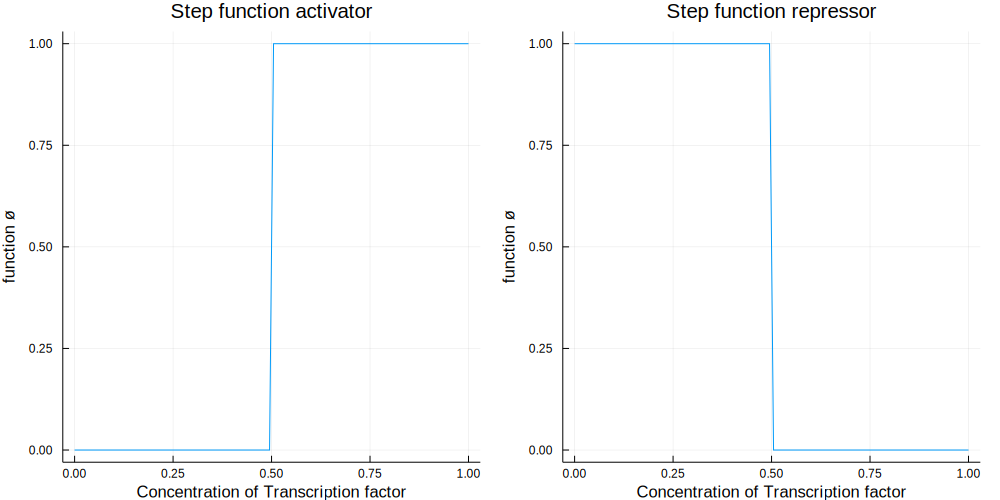

In [82]:
T_vector= LinRange(0,1,100)
n=1000
K=0.5
ϕ=T_vector.^n./(K.^n.+T_vector.^n)
P1=plot(T_vector,ϕ,lab="")
title!("Step  function activator")
xlabel!("Concentration of Transcription factor")
ylabel!("function ø")

ϕ=K.^n./(K.^n.+T_vector.^n)
P2=plot(T_vector,ϕ,lab="")
title!("Step function repressor")
xlabel!("Concentration of Transcription factor")
ylabel!("function ø")


plot(P1,P2,layout=(1,2),legend=true,size = (1000, 500))

A more realistic scenario (and mathematically easier) is that the probability of transcription is a sigmoidal. 

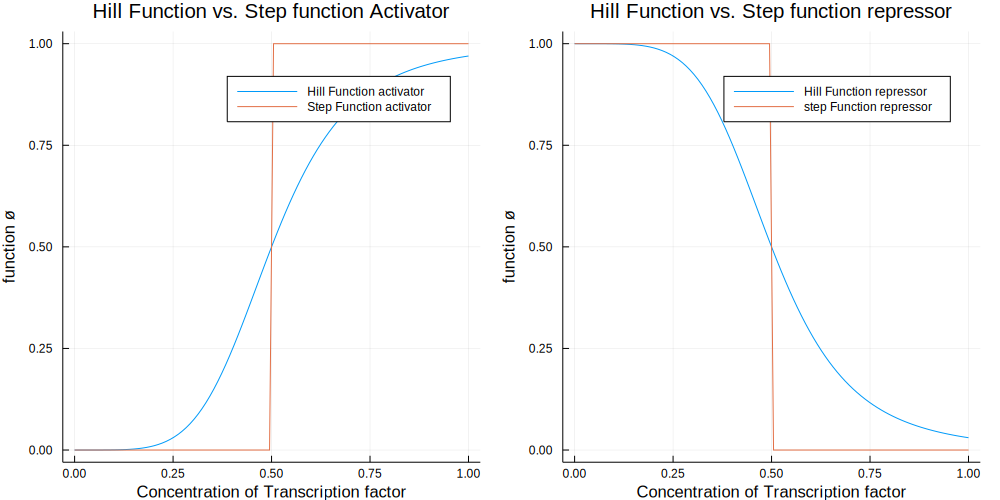

In [83]:
n=5
ϕ=T_vector.^n./(K.^n.+T_vector.^n)
P1=plot(T_vector,ϕ,lab="Hill Function activator")

n=1000
ϕ=T_vector.^n./(K.^n.+T_vector.^n)
P1=plot!(T_vector,ϕ,lab="Step Function activator")

title!("Hill Function vs. Step function Activator")
xlabel!("Concentration of Transcription factor")
ylabel!("function ø")

n=5
ϕ=K.^n./(K.^n.+T_vector.^n)
P2=plot(T_vector,ϕ,lab="Hill Function repressor")

n=1000
ϕ=K.^n./(K.^n.+T_vector.^n)
P2=plot!(T_vector,ϕ,lab="step Function repressor")
title!("Hill Function vs. Step function repressor")
xlabel!("Concentration of Transcription factor")
ylabel!("function ø")

plot(P1,P2,layout=(1,2),legend=true,size = (1000, 500))


Therefore, the most common approach is to use a Hill function. For an activator:

$$
\frac{\mathrm{d} [M]}{\mathrm{d} t}= k_M \frac{[T^n][D]}{K^n+[T^n]}-\gamma_M[M]= \alpha_M \frac{[T^n]}{K^n+[T^n]}-\gamma_M[M] \tag{4}
$$
and for repression, we have

$$
\frac{\mathrm{d} [M]}{\mathrm{d} t}= k_M \frac{K^n[D]}{K^n+[T^n]}-\gamma_M[M]= \alpha_M \frac{K^n}{K^n+[T^n]}-\gamma_M[M] \tag{5}
$$

where we defined  $\alpha_M= k_M [D]$ as the maximum transcription rate of mRNA `M`. The set of interactions is then generalized as:

$$
\begin{matrix}
\Psi (T,K) &\overset{α_M}{\longrightarrow}& M \tag{6}\\ 
M &\overset{\gamma_M}{\longrightarrow}& 0
\end{matrix}
$$

illustrating that the production of `M` is defined by a function $\Psi$ of the amount of transcription factor `T` and the constant of the Hill funcion `K` that corresponds to the half maximal concetration of transcripton factor. This function can refer to the Hill function for activator or for repressor. Now if se solve these differential equations:

In [8]:
function CentralDogma_activator_Hill!(du,u,p,t)
    α_M,γ_M,T,n,K= p
    du[1] = -γ_M*u[1]+α_M*T^n/(K^n +T^n)
end

function CentralDogma_represor_Hill!(du,u,p,t)
    α_M,γ_M,T,n,K= p
    du[1] = -γ_M*u[1]+α_M*K^n/(K^n +T^n)
end

CentralDogma_represor_Hill! (generic function with 1 method)

but we prefer to use the simplest DSL notation

In [81]:
CentralDogma_activator_Hill_DSL! = @ode_def ab begin
   dM = -γ_M*M+α_M*T^n/(K^n +T^n)
    end α_M γ_M T n

CentralDogma_repressor_Hill_DSL! = @ode_def ab begin
   dM = -γ_M*M+α_M*K^n/(K^n +T^n)
    end α_M γ_M T n

(::ab{getfield(Main, Symbol("##83#87")),getfield(Main, Symbol("##84#88")),getfield(Main, Symbol("##85#89")),Nothing,Nothing,getfield(Main, Symbol("##86#90")),Expr,Expr}) (generic function with 2 methods)

In [126]:
n=5
k_M=1
K=1
T=1
α_M=k_M*D
p=[α_M,γ_M,T,n];
tspan = (0.0,10.0)
u₀ = [0.02]
prob3 = ODEProblem(CentralDogma_activator_Hill_DSL!,u₀,tspan,p)
u₀ = [0.02]
prob4 = ODEProblem(CentralDogma_repressor_Hill_DSL!,u₀,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [0.02]

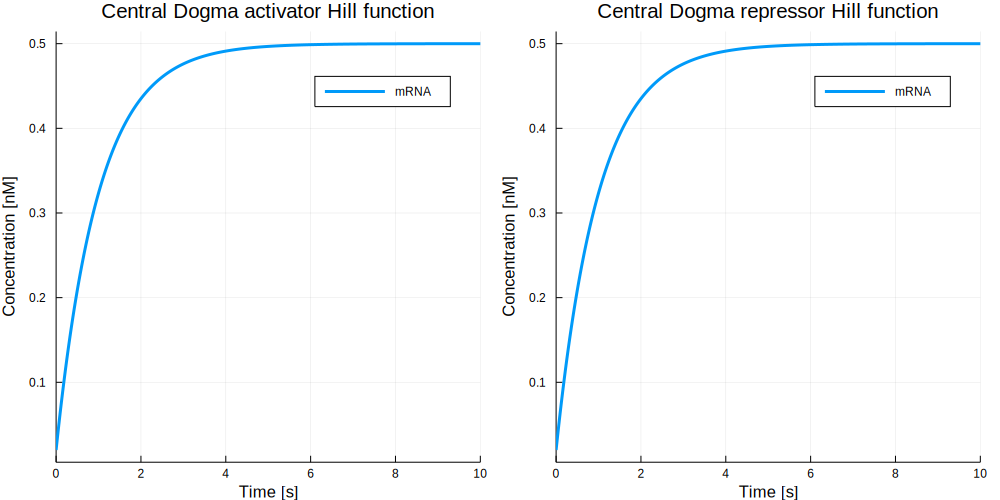

In [125]:
sol3 = solve(prob3)
sol4 = solve(prob4)
P3=plot(sol3,label=["mRNA"])
title!("Central Dogma activator Hill function")
xlabel!("Time [s]")
ylabel!("Concentration [nM]")
P4=plot(sol4,label=["mRNA"])
title!("Central Dogma repressor Hill function")
xlabel!("Time [s]")
ylabel!("Concentration [nM]")
plot(P3,P4,layout=(1,2),legend=true,size = (1000, 500))

The effect of the Hill function is more apparent if we change the concentration of transcription factor. Now we see the saturation effect of the Hill equation. 

In [104]:
function CentralDogma_activator_parameters(α_M,γ_M,T,n)
     p=[α_M,γ_M,T,n];
     prob3 = ODEProblem(CentralDogma_activator_Hill_DSL!,u₀,tspan,p)
     sol3 = solve(prob3)
     x=("T = $(T)")
     plot!(sol3,label=x)
end

function CentralDogma_repressor_parameters(α_M,γ_M,T,n)
     p=[α_M,γ_M,T,n];
     prob4 = ODEProblem(CentralDogma_repressor_Hill_DSL!,u₀,tspan,p)
     sol4 = solve(prob4)
     x=("T = $(T)")
     plot!(sol4,label=x)
end

CentralDogma_repressor_parameters (generic function with 1 method)

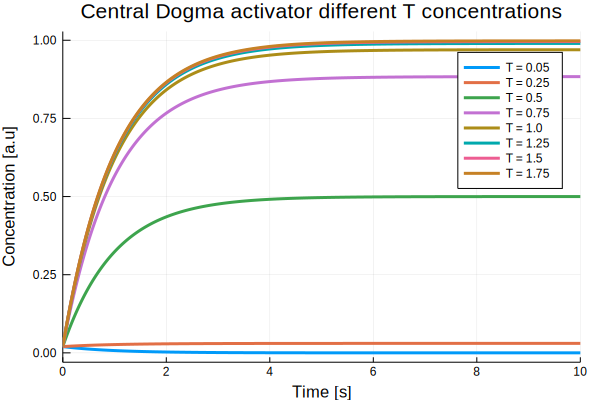

In [127]:
u₀ = [0.02]
n=5
k_M=1
K=0.5
D=1
α_M=k_M*D
γ_M=1
T=1

plot()
for i in [0.05,0.25,0.5,0.75,1,1.25,1.5,1.75]
    CentralDogma_activator_parameters(α_M,γ_M,i,n)
end
title!("Central Dogma activator different T concentrations")
xlabel!("Time [s]")
ylabel!("Concentration [a.u]")

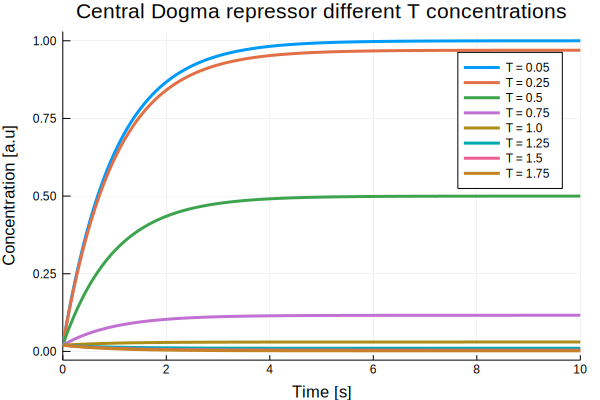

In [128]:
u₀ = [0.02]
n=5
k_M=1
K=0.5
D=1
α_M=k_M*D
γ_M=1

plot()
for i in [0.05,0.25,0.5,0.75,1,1.25,1.5,1.75]
    CentralDogma_repressor_parameters(α_M,γ_M,i,n)
end
title!("Central Dogma repressor different T concentrations")
xlabel!("Time [s]")
ylabel!("Concentration [a.u]")

As we can see, the profiles look quite similar, but the order of the plots is inverted, i.e., the plots corresponding with the lowest concetration of `T` are below when using the activator Hill function (blue line). The same values of `T` result in the plots above when using a repressor (blue line).  

## Protein dynamics

After analyzing the effect induced by the Hill function, the next step is to add the dynamics of the protein. The reactions that take place can be illustrated as:

$$
\begin{matrix}
\Psi (T,K) &\overset{α_M}{\longrightarrow}& M \tag{7}\\ 
M &\overset{\gamma_M}{\longrightarrow}& 0 \\
M &\overset{\alpha_P}{\longrightarrow}& P \\
P &\overset{\gamma_P}{\longrightarrow}& 0
\end{matrix}
$$

where `P` is the concentration of protein, $\alpha_P$ and $\gamma_P$ correspond to syntehsis and degradation of `P`. Explicitely, for activators, the set of differential equations is:

$$
\begin{align*}
\frac{\mathrm{d} [M]}{\mathrm{d} t} &=  \alpha_m \frac{[T]^n}{K^n+[T]^n}-\gamma_M[M] \tag{8}\\ 
\frac{\mathrm{d} [P]}{\mathrm{d} t} &=  \alpha_P [M]-\gamma_P[P]
\end{align*}
$$

and for repressors: 

$$
\begin{align*}
\frac{\mathrm{d} [M]}{\mathrm{d} t} &=  \alpha_m \frac{K^n}{K^n+[T]^n}-\gamma_M[M] \tag{9}\\ 
\frac{\mathrm{d} [P]}{\mathrm{d} t} &=  \alpha_P [M]-\gamma_P[P]
\end{align*}
$$



In [141]:
CentralDogma4_DSL! = @ode_def ab begin
   dM = -γ_M*M+α_M*T^n/(K^n +T^n)
   dP =   α_P * M - γ_P * P
    end α_M γ_M T n α_P γ_P

CentralDogma5_DSL! = @ode_def ab begin
   dM = -γ_M*M+α_M*K^n/(K^n +T^n)
   dP =   α_P * M - γ_P * P
    end α_M γ_M T n α_P γ_P

(::ab{getfield(Main, Symbol("##115#119")),getfield(Main, Symbol("##116#120")),getfield(Main, Symbol("##117#121")),Nothing,Nothing,getfield(Main, Symbol("##118#122")),Expr,Expr}) (generic function with 2 methods)

In [142]:
tspan = (0.0,10.0)
n=5
k_M=1
K=1
D=1
α_M=k_M*D
γ_M=1
α_P=0.5
γ_P=0.1
T=1

p=[α_M,γ_M,T,n,α_P,γ_P,K];

u₀ = [0.01,0.00001]
prob3 = ODEProblem(CentralDogma4_DSL!,u₀,tspan,p)
u₀ = [0.01,0.00001]
prob4 = ODEProblem(CentralDogma5_DSL!,u₀,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [0.01, 1.0e-5]

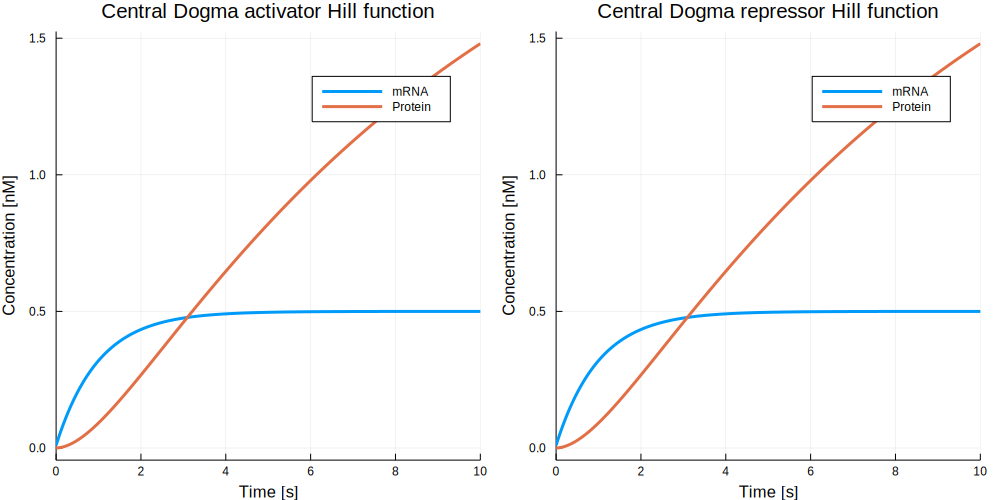

In [143]:
sol3 = solve(prob3)
sol4 = solve(prob4)
P3=plot(sol3,label=["mRNA","Protein"])
title!("Central Dogma activator Hill function")
xlabel!("Time [s]")
ylabel!("Concentration [nM]")
P4=plot(sol4,label=["mRNA","Protein"])
title!("Central Dogma repressor Hill function")
xlabel!("Time [s]")
ylabel!("Concentration [nM]")
plot(P3,P4,layout=(1,2),legend=true,size = (1000, 500))

which are, as expected equivalent. The interssting thing occurs when we test different concetrations of the transcription factor `T`.

In [168]:
function CentralDogma_activator_parameters(α_M,γ_M,T,n,α_P,γ_P,K)
     p=[α_M,γ_M,T,n,α_P,γ_P,K];
     prob3 = ODEProblem(CentralDogma4_DSL!,u₀,tspan,p)
     sol3 = solve(prob3)
     x=("T = $(T)")
     plot!(sol3,vars=(2),label=x)
end

function CentralDogma_repressor_parameters(α_M,γ_M,T,n,α_P,γ_P,K)
     p=[α_M,γ_M,T,n,α_P,γ_P,K];
     prob4 = ODEProblem(CentralDogma5_DSL!,u₀,tspan,p)
     sol4 = solve(prob4)
     x=("T = $(T)")
     plot!(sol4,vars=(2),label=x)
end

CentralDogma_repressor_parameters (generic function with 2 methods)

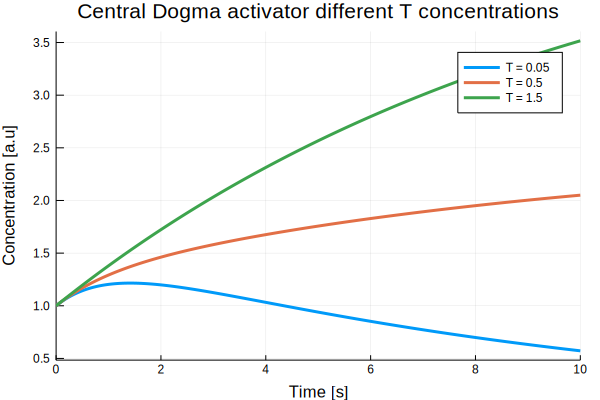

In [173]:
u₀ = [1.0,1.0]
n=5
k_M=1
K=0.5
D=1
α_M=k_M*D
γ_M=1
T=1

plot()
for i in [0.05,0.5,1.5]
   CentralDogma_activator_parameters(α_M,γ_M,i,n,α_P,γ_P,K)
end
title!("Central Dogma activator different T concentrations")
xlabel!("Time [s]")
ylabel!("Concentration [a.u]")

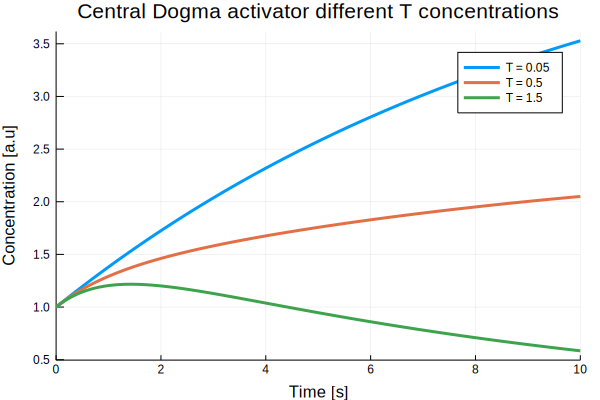

In [174]:
plot()
for i in [0.05,0.5,1.5]
   CentralDogma_repressor_parameters(α_M,γ_M,i,n,α_P,γ_P,K)
end
title!("Central Dogma activator different T concentrations")
xlabel!("Time [s]")
ylabel!("Concentration [a.u]")

In conclusion, both the activator form and the repressor forms of the Hill function can be used to model numerically the transctiption and translation of mRNA into protein regulated by transcriptional activators and represors, respectively. The dynamics is similar, but the dependence on the amount of transcription factor `T` is reversed. 